# Projet majeur : Détection du port de masques à l'aide de machine learning

Plusieurs gouvernements ont créé de nouvelles réglementations pour protéger leur population contre le virus. L'une de ces nouvelles règles était le masque Fase obligatoire.

Malheureusement, tout le monde ne suit pas les règles. Certains ont trouvé acceptable de mettre en danger d'autres personnes en portant leur masque de manière incorrecte ou pas du tout.

Ce projet aidera à identifier ces personnes dans les images.

# Quelques details bons à savoir

Ce notebook utilisera le modèle YOLOv5 pour la détection d'objets. Il utilise un réseau de neurones profonds, ce qui facilite son recyclage sur un ensemble de données personnalisé.

L'ensemble de données utilisé sera celui de Kaggle. Le jeu de données de détection de masque facial (Source : https://www.kaggle.com/andrewmvd/face-mask-detection) contient deux dossiers :

*  Images (853) - photos de personnes portant des masques correctement, incorrectement ou n'en portant aucun
*  Annotations - fichiers xml décrivant la façon dont le masque est porté.

# Packages et bibliothèques

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
from sklearn.model_selection import train_test_split
from IPython.display import Image # display detectedd images
from glob import glob # retrieve files/pathnames matching a specified pattern
import matplotlib.pyplot as plt # collection of functions in visualization package Matplotlib
import xml.etree.ElementTree as ET

# Import des données et architecture

YOLO (You Only Look Once) est un algorithme de détection d’objets et est apparu avec l’article “You Only Look Once Unified, Real-Time Object Detection” par Joseph Redmon. Les deux versions qui ont suivi ont également été créées par Redmon.

Le modèle que j’utilise, YOLOv5,  a été créé par Ultralytics en utilisant Pytorch (bibliothèque deep learning). Cette version aurait une précision moyenne supérieure par rapport à ces précédentes versions.

Avec YOLO, un seul CNN prédit simultanément plusieurs cadres de délimitation et probabilités de classe pour ces cadres. YOLO s'entraîne sur des images complètes et optimise directement les performances de détection.

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 7253, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 7253 (delta 228), reused 229 (delta 131), pack-reused 6878
Receiving objects: 100% (7253/7253), 9.20 MiB | 20.94 MiB/s, done.
Resolving deltas: 100% (4956/4956), done.
/content/yolov5


In [ ]:
 pip install -r requirements.txt 

Ce document contient une liste de packages et de bibliothèques nécessaires dans les parties suivantes. La plupart des exigences sont déjà installées. (Particularité de Google Colab)

Sauf thop (flops du modèle Pytorch, calcul des paramètres) et PyYAML (analyseur et émetteur YAML pour Python) nécessaire au fichier Yolo Yalm. (voir section)

In [ ]:
# Create directories
!mkdir -p Kaggle # kaggle dataset destination
!mkdir -p Dataset/FaceMask/Images 
!mkdir -p Dataset/FaceMask/Labels

Avant de pouvoir importer le dataset, il faut ajouter le fichier kaggle.json au répertoire "Kaggle". Ce fichier comporte mon nom d'utilisateur et la clé nécessaire à l'import.

In [ ]:
# import du dataset Kaggle dans le répertoire "Kaggle" créé
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/yolov5/Kaggle"
%cd /content/yolov5/Kaggle
!kaggle datasets download -d andrewmvd/face-mask-detection --unzip
%cd ..

/content/yolov5/Kaggle
 95% 377M/398M [00:03<00:00, 104MB/s]
100% 398M/398M [00:03<00:00, 113MB/s]
/content/yolov5


In [ ]:
!cp -rf /content/yolov5/Kaggle/images/* Dataset/FaceMask/Images # copier les images du dataset vers dossier Images

In [ ]:
!mkdir -p Dataset/images Dataset/labels

In [ ]:
FILE_ROOT = "/content/yolov5/Kaggle/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "annotations"

DATA_ROOT = "Dataset/"
LABELS_ROOT = DATA_ROOT + "FaceMask/Labels"
IMAGES_ROOT = DATA_ROOT + "FaceMask/Images"  

DEST_IMAGES_PATH = "images"
DEST_LABELS_PATH = "labels"

classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

Maintenant que nos répertoires sont créés et toutes nos importations ont été effectué, je peux passer à l'étape suivante.

Pour entraîner le modèle YOLOv5, il faut organiser la structure du dataset. Pour cela, le modèle nécessite de changer les formats du dataset : les fichiers xml en txt.

#  Création du format YOLO (Preprocessing)

Conversion des annotations (from COCO .xml to YOLO format .txt)

In [ ]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def save_file(img_jpg_file_name, size, img_box):
    save_file_name = LABELS_ROOT + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:

        cls_num = classes.index(box[0])

        new_box = cord_converter(size, box[1:])

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        # print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [ ]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

Le script ci-dessus va utiliser les fonctions précédentes pour venir chercher les informations des fichiers xml du dossier "annotations" du dataset Kaggle. Il les écrit dans leur fichier texte correspondant dans le répertoire Dataset/Facemask/Labels créé auparavant.

Exemple :

/content/yolov5/Kaggle/annotations/maksssksksss577.xml 
Dataset/FaceMask/Labels/maksssksksss577.txt

# Séparation du dataset en "train" et "test"

In [ ]:
# Split images among train, test and val lists
image_list = os.listdir('Dataset/FaceMask/Images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=7)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=8)

print('total count :',len(image_list))
print('train :',len(train_list))
print('test :',len(test_list))
print('validation :',len(val_list))

total count : 853
train : 682
test : 86
validation : 85


Déplacement des images vers les dossiers "train" et "test" :

In [ ]:
def copy_data(file_list, img_labels_root, imgs_source, type):

    root_file = Path(DATA_ROOT + DEST_IMAGES_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    root_file = Path(DATA_ROOT + DEST_LABELS_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    for file in file_list:
        img_name = file.replace('.png', '')
        img_src_file = imgs_source + '/' + img_name + '.png'
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        # Copy image
        DICT_DIR = DATA_ROOT + DEST_IMAGES_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = DATA_ROOT + DEST_LABELS_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [ ]:
 # Association des images et annotations créées précedemment
copy_data(train_list, LABELS_ROOT, IMAGES_ROOT, "train")
copy_data(val_list,   LABELS_ROOT, IMAGES_ROOT, "val") 
copy_data(test_list,  LABELS_ROOT, IMAGES_ROOT, "test") 

Path Dataset/images/train is not exit
Path Dataset/labels/train is not exit
Path Dataset/images/val is not exit
Path Dataset/labels/val is not exit
Path Dataset/images/test is not exit
Path Dataset/labels/test is not exit


# Création du fichier Yolo Yalm 

Ce fichier décrit l'architecture générale du modèle, la manière de le configurer et comment le déployer. 

In [ ]:
!echo "train: Dataset/images/train" >> data/facemask.yaml
!echo "val:   Dataset/images/val" >> data/facemask.yaml
!echo "nc : 3" >> data/facemask.yaml
!echo "names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']" >> data/facemask.yaml

!cat data/facemask.yaml

train: Dataset/images/train
val:   Dataset/images/val
nc : 3
names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']


# Entraînement du modèle YOLOv5

Il est nécessaire d'entraîner le modèle pour permettre au réseau de neurones de déduire la classe correspondante dnas chaque image.

Je vais entraîner le modèle sur 100 epochs. Un "epoch" correspond à un processus d'apprentissage sur toutes les données. Le nombre d'epochs influence la précision, mais aussi le temps que va prendre l'entraînement. 

In [ ]:
!python train.py --img 320 --batch 16 --epochs 100 --data data/facemask.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/facemask.yaml, hyp=data/hyp.scratch.yaml, epochs=100, batch_size=16, img_size=[320], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket=, cache_images=False, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-220-ge8810a5 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, sc

GPU : 100 epochs terminés en 0.696 heures : 
* All : mAP@.5 = 0.651 => précision moyenne 65.1 % 
* With mask : mAP@.5 = 0.896
* Whithout mask : mAP@.5 = 0.586
* Incorrect mask : mAP@.5 = 0.47

Avec 30 epochs (0.209 heures), je n'ai obtenu qu'une présision moyenne de 48.8% sur toutes les données.

Après la fin de l'entraînement, je copies les "weights" ("poids") pour y accéder plus facilement. Ces "poids" contrôlent la force de la connexion entre deux neurones.Ou encore, lorsque les entrées sont transmises entre les neurones, les poids sont appliqués aux entrées avec une valeur supplémentaire (le biais)

In [ ]:
!cp runs/train/exp/weights/best.pt weights

# Visualisation des résultats du modèle entraîné

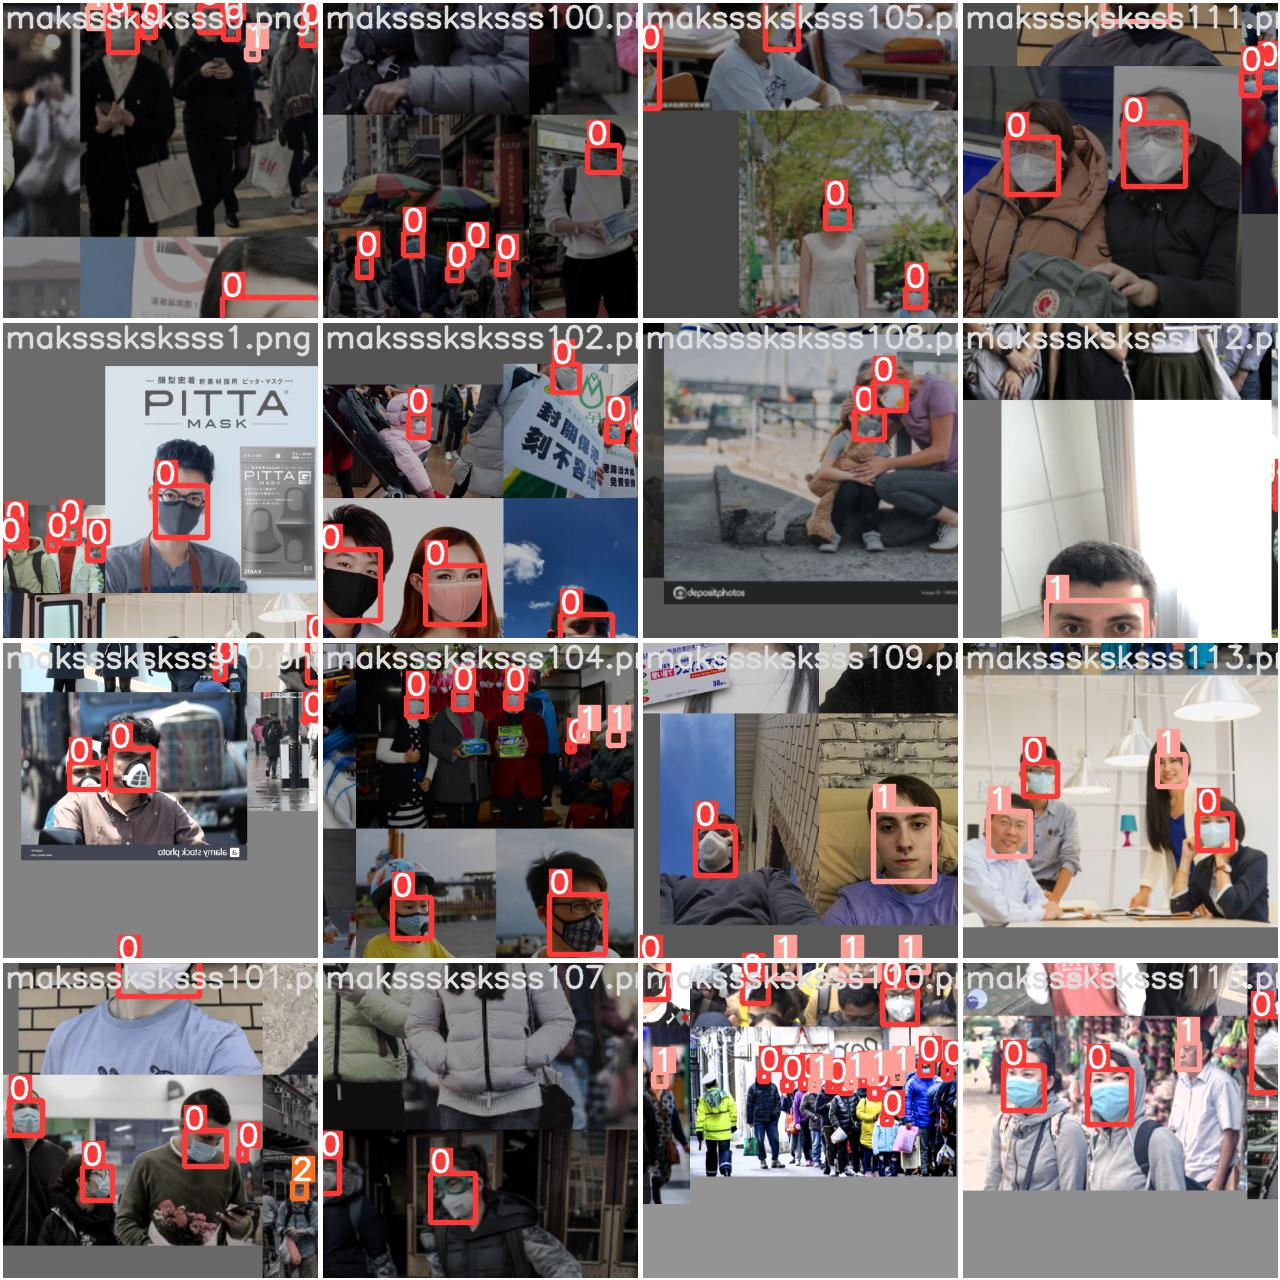

In [ ]:
Image(filename='/content/yolov5/runs/train/exp/train_batch0.jpg', width=800)  # train_batch_0 mosaics and labels

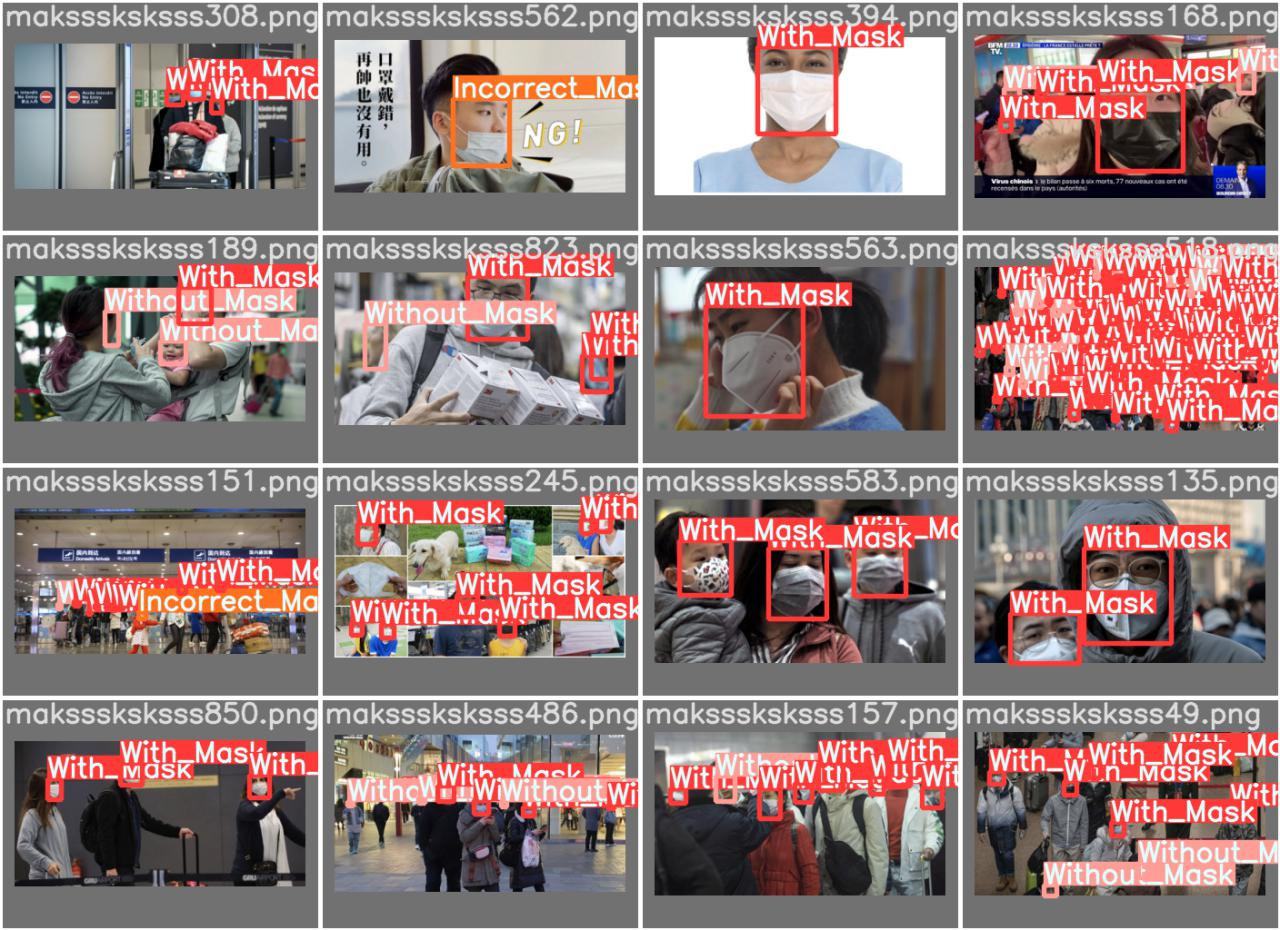

In [ ]:
Image(filename='/content/yolov5/runs/train/exp/test_batch0_labels.jpg', width=800)  # test_batch_0 labels

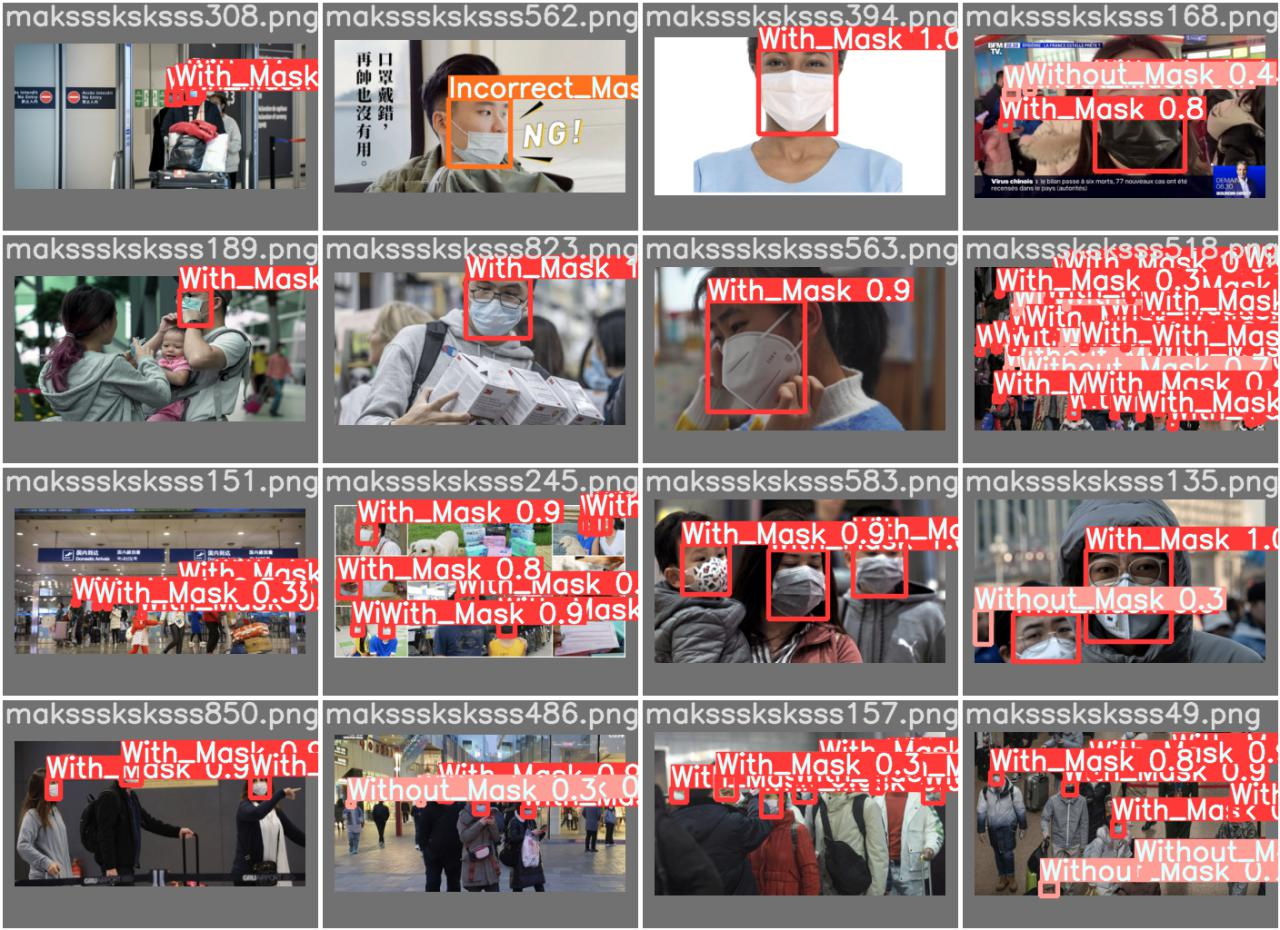

In [ ]:
Image(filename='/content/yolov5/runs/train/exp/test_batch0_pred.jpg', width=800)  # test_batch_0 predictions

With 30 epochs, some of the "incorrect_mask" are predicted to be "without_mask"

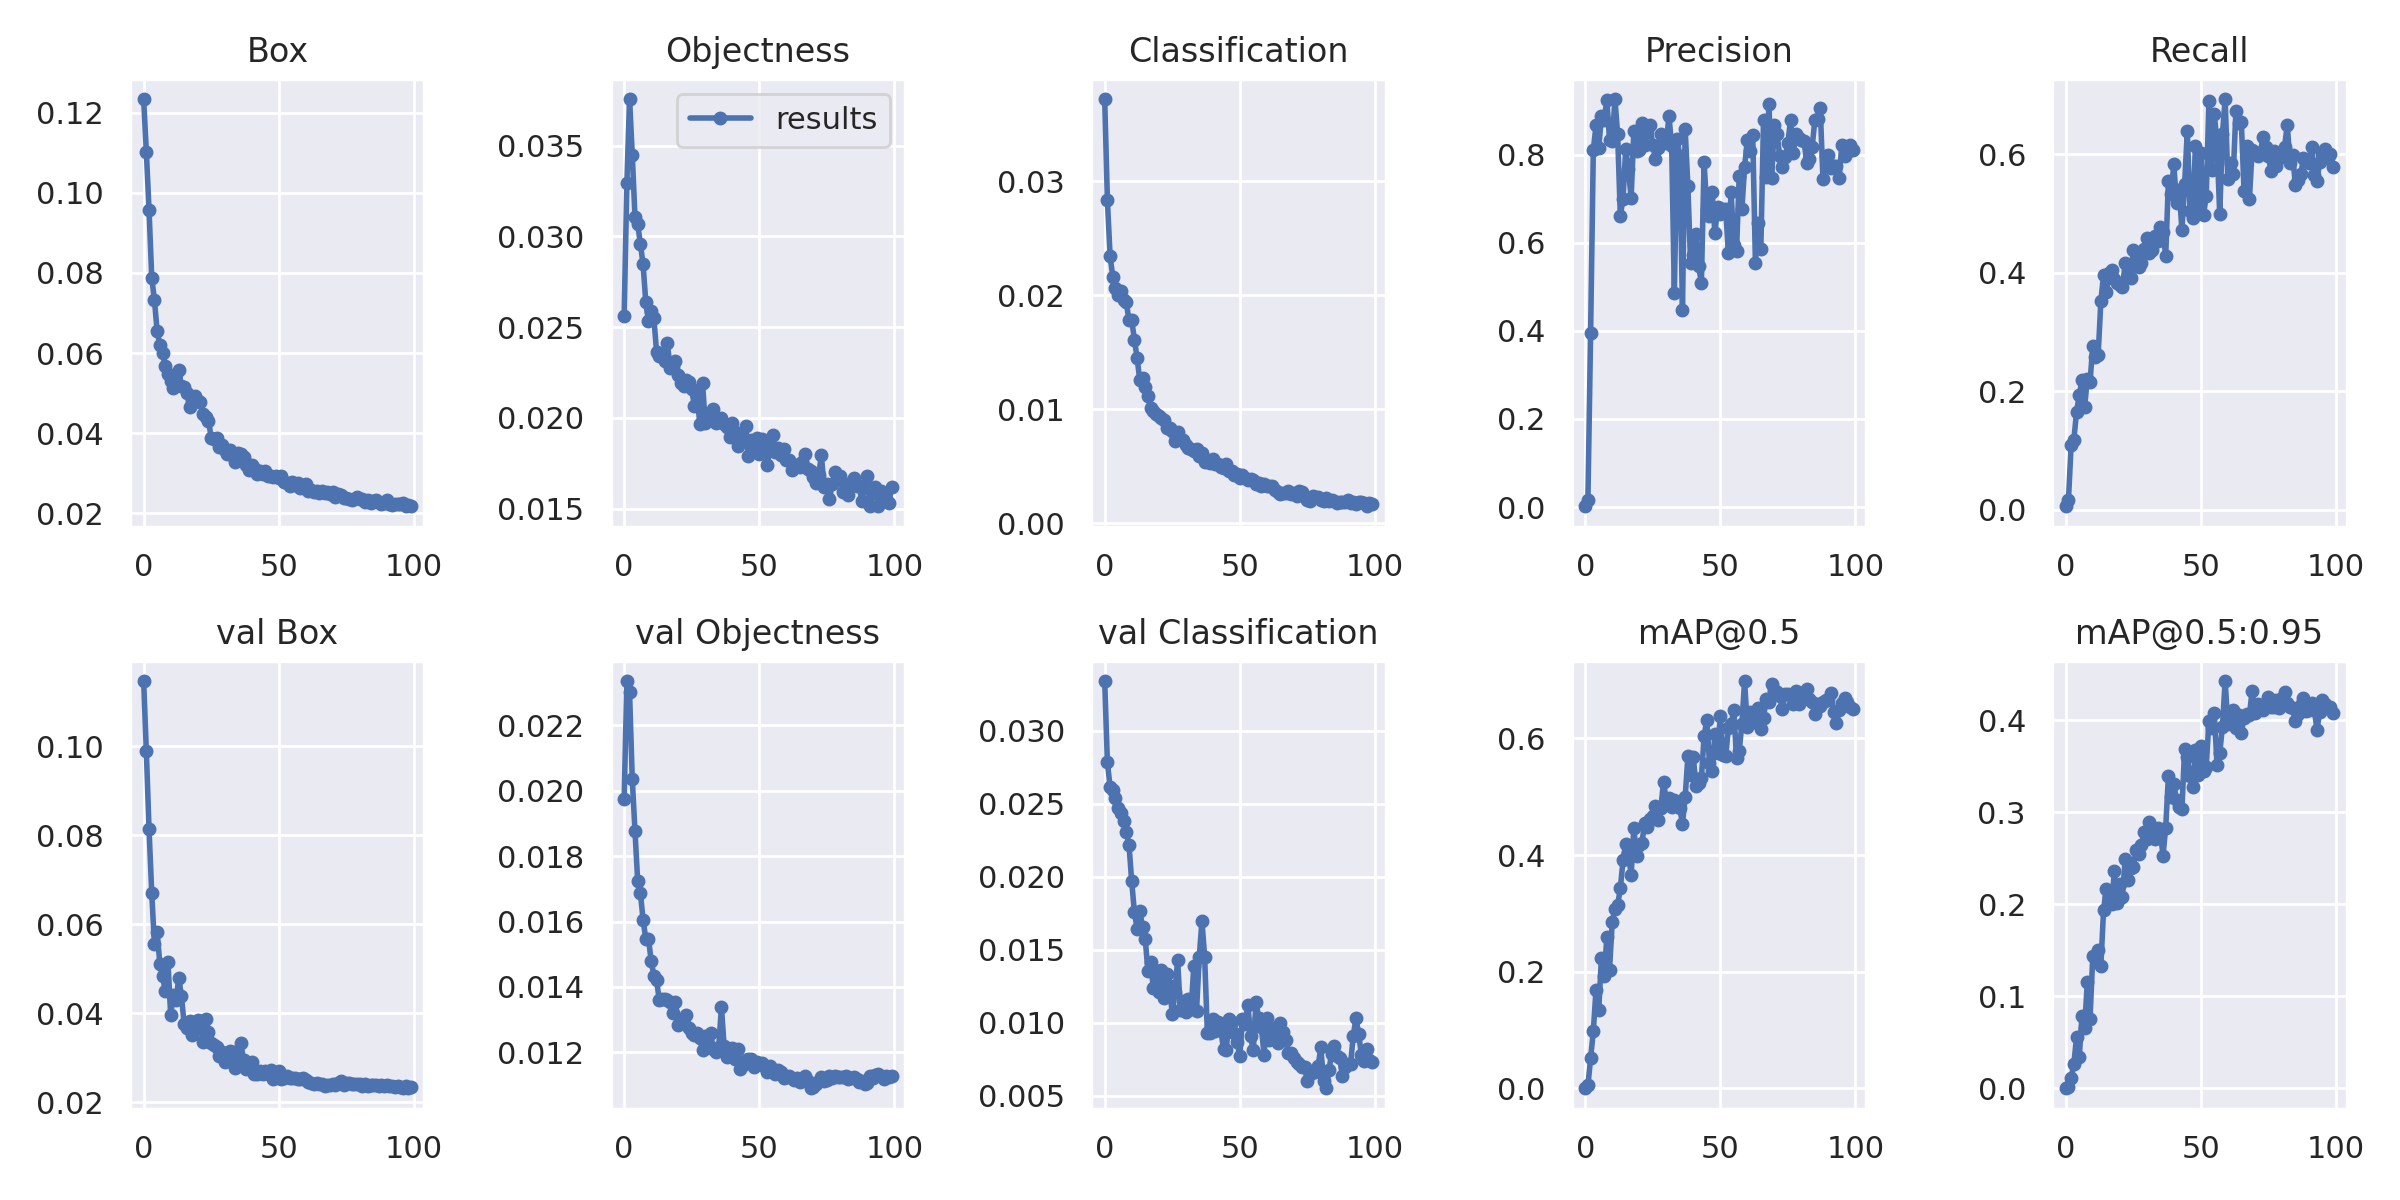

In [ ]:
#plot_results(save_dir='/content/yolov5/runs/train/exp')  # plot all results*.txt as results.png
Image(filename='runs/train/exp/results.png', width=800)

Sur l'image ci-dessus, je peux observer que la précision moyenne est environ égale à 65%.

# Inférence

Maintenant, je vais utiliser detect.py qui utilise le modèle entraîné pour inférer, et donc prédire, les valeurs d'étiquette en fonction de ses caractéristiques. Le script enregistre les résultats dans "runs/detect"

In [ ]:
!python detect.py --source Dataset/images/test --img-size 320 --conf 0.4 --weights weights

detect: weights=['weights'], source=Dataset/images/test, imgsz=320, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-220-ge8810a5 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPs
image 1/86 /content/yolov5/Dataset/images/test/makss

Tous les résultats ont été sauvegardés dans le répertoire "runs/detect/exp"

Exemple de résultat :

<function matplotlib.pyplot.show>

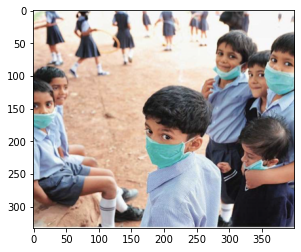

In [ ]:
testfiles = glob('runs/detect/exp/*')

img = plt.imread(IMAGE_PATH+ "/maksssksksss698.png") # read an image from a file into an array
plt.imshow(img) # display data as an image
plt.show # display figure

Ensuite, je vais "détecter" les masques sur l'image à l'aide du modèle entraîné.

In [ ]:
!python detect.py --source "/content/yolov5/Kaggle/images/maksssksksss698.png" --img-size 320 --conf 0.4 --weights weights

detect: weights=['weights'], source=/content/yolov5/Kaggle/images/maksssksksss698.png, imgsz=320, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-220-ge8810a5 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPs
image 1/1 /content/yol

Le modèle a détécté 2 personnes portant un masque correctement, 3 personnes sans masque et 5 personnes qui le portent incorrectement.

Les résultats sont sauvegardés dans le répertoire "runs/detect/exp2"

<function matplotlib.pyplot.show>

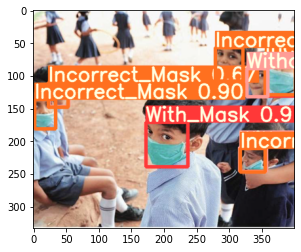

In [ ]:
img = plt.imread("runs/detect/exp2/maksssksksss698.png") 
plt.imshow(img)    
plt.show

Autre exemple de résultat :

<function matplotlib.pyplot.show>

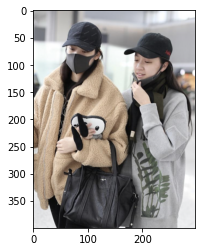

In [ ]:
img = plt.imread(IMAGE_PATH+ "/maksssksksss459.png") 
plt.imshow(img)    
plt.show

In [ ]:
!python detect.py --source "/content/yolov5/Kaggle/images/maksssksksss459.png" --img-size 320 --conf 0.4 --weights weights

detect: weights=['weights'], source=/content/yolov5/Kaggle/images/maksssksksss459.png, imgsz=320, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-220-ge8810a5 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPs
image 1/1 /content/yol

Le modèle a détécté 1 personne portant un masque correctement et 1 personne qui le porte incorrectement.

Les résultats sont sauvegardés dans le répertoire "runs/detect/exp3"

<function matplotlib.pyplot.show>

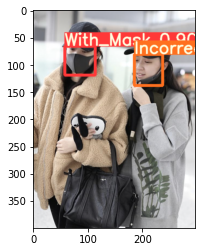

In [ ]:
img = plt.imread("runs/detect/exp3/maksssksksss459.png") 
plt.imshow(img)    
plt.show

# Résultat

<function matplotlib.pyplot.show>

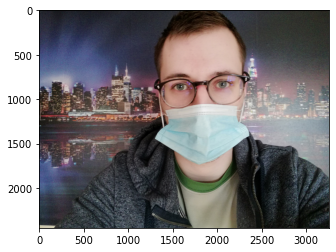

In [ ]:
img = plt.imread("/content/yolov5/Correct.jpg")
plt.imshow(img)    
plt.show

In [ ]:
!python detect.py --source "/content/yolov5/Correct.jpg" --img-size 320 --conf 0.4 --weights weights

detect: weights=['weights'], source=/content/yolov5/Correct.jpg, imgsz=320, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-220-ge8810a5 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPs
image 1/1 /content/yolov5/Correct.jpg: 256x3

1 With_Mask => "runs/detect/exp4"

<function matplotlib.pyplot.show>

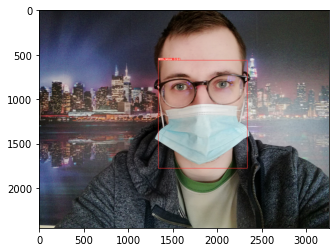

In [ ]:
img = plt.imread("runs/detect/exp4/Correct.jpg") 
plt.imshow(img)    
plt.show

<function matplotlib.pyplot.show>

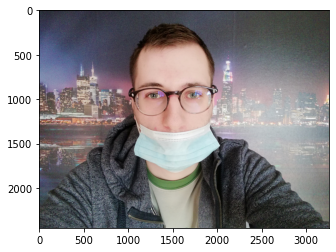

In [ ]:
img = plt.imread("/content/yolov5/Incorrect.jpg")
plt.imshow(img)    
plt.show

In [ ]:
!python detect.py --source "/content/yolov5/Incorrect.jpg" --img-size 320 --conf 0.4 --weights weights

detect: weights=['weights'], source=/content/yolov5/Incorrect.jpg, imgsz=320, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-220-ge8810a5 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPs
image 1/1 /content/yolov5/Incorrect.jpg: 2

1 Incorrect_Mask => "runs/detect/exp5"

<function matplotlib.pyplot.show>

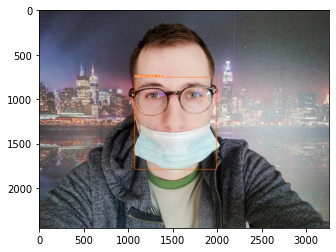

In [ ]:
img = plt.imread("runs/detect/exp5/Incorrect.jpg") 
plt.imshow(img)    
plt.show